# Imports & Configs

In [ ]:
import numpy as np 
import pandas as pd
from functools import partial
import math
import csv

import sklearn # sklearn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE # class imbalance

from xgboost import XGBClassifier # xgboost

import matplotlib.pyplot as plt # plotting
import seaborn as sns



In [ ]:
pd.options.display.max_rows = 100
np.set_printoptions(precision=3,threshold=np.inf)

# Load the data

In [ ]:
def load(path):
    df = pd.read_csv(path)

    X = df.drop(['CITY',                # missing values
                'USER_AGENT',          # missing values
                'FRAUD_FLAG',          # target
                'TRANSACTION_ID',      # uid
                'EVENT_TIME',          # ignore these variables for now
                'EVENT_MONTH',         #
                'EVENT_DAY_OF_WEEK'],  #
                axis=1)

    y = df['FRAUD_FLAG']

    return X, y, df

X, y, _ = load('train_ScotiaDSD.csv')

## Train/test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=0
)

X_train_np, X_test_np = X_train.to_numpy(), X_test.to_numpy()



# Training XGBoost

In [ ]:
def train_xgboost(train, learning_rate=0.1, max_depth=3, min_child_weight=1, gamma=0.0, pos_weight=1):
    xgboost = XGBClassifier(
        learning_rate = learning_rate,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        gamma = gamma,
        scale_pos_weight=pos_weight
    )
    X_train, y_train = train

    xgboost.fit(X_train, y_train)

    return xgboost

In [ ]:
# XGBoost Baseline

model_base = train_xgboost(
    (X_train_np, y_train), 
    0.1, 3, 1, 0.0)

In [ ]:
# SMOTE

X_train_smote, y_train_smote = SMOTE(sampling_strategy=1/9).fit_resample(X_train_np, y_train)
print(sum(y_train_smote)/len(y_train_smote))

model_smote = train_xgboost(
    (X_train_smote, y_train_smote), 
    0.1, 3, 1, 0.0)

In [ ]:
# best hyperparams
model = train_xgboost(
    (X_train_np, y_train), 
    learning_rate=0.1,
    max_depth=15,
    min_child_weight=15,
    gamma=1.0
)

# Submission file

In [ ]:
# train on all the data
X_all, _, y_all, _ = train_test_split(
    X, y,
    test_size=0.001,
    random_state=0
)
X_all_np = X_all.to_numpy()

model_all = train_xgboost(
    (X_all_np, y_all), 
    learning_rate=0.1,
    max_depth=15,
    min_child_weight=15,
    gamma=1.0
)

In [ ]:
X_holdout, y_holdout, df_holdout = load('test_ScotiaDSD.csv')
X_holdout_np = X_holdout.to_numpy()

In [ ]:
def generate_preds(model, X, df, t):

    raw_probs = prob(model, X)
    preds = raw_probs >= t
    adjusted_probs = np.minimum(np.maximum(raw_probs + (0.5-t),np.zeros(len(X))), np.ones(len(X)))
    ids = df['TRANSACTION_ID']
    amounts = df['AMOUNT']

    return ids, adjusted_probs, preds, amounts

In [ ]:
holdout_ids, adjusted_probs, preds, amounts = generate_preds(model_all, X_holdout_np, df_holdout, 0.21)

In [ ]:
def write_csv(ids, preds, probs):
    with open('results.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["TRANSACTION_ID", "PREDICTION", "PROBABILITY"])
        for i in range(len(ids)):
            writer.writerow([ids[i], 1.0 if preds[i] else 0.0, probs[i]])
        

write_csv(holdout_ids, preds, adjusted_probs)

# Evaluation

In [ ]:
# utility functions

def optimal(prob, label, f = f1_score):
    max_val = 0
    optimal_t = 0
    lst = []
    for t in range(100):
        val = f(label, prob >= t/100)
        lst.append(val)
        if val > max_val:
            max_val = val
            optimal_t = t
    
    return max_val, optimal_t/100, lst

def prob(model, X): 
    return model.predict_proba(X)[:,1]

def metrics(y, preds):
    print('F1:', f1_score(y, preds))
    print('Precision:', precision_score(y, preds))
    print('Recall:', recall_score(y, preds))
    print('Conf Matrix:', sklearn.metrics.confusion_matrix(y, preds))

def fp(y, preds):
    return sum(np.logical_and(y == 0, preds == True))

def fpr(y, preds):
    return sum(np.logical_and(y == 0, preds == True))/sum(y==0)


In [ ]:
# calc probabilities
prob_train = prob(model, X_train_np)
prob_test = prob(model, X_test_np)

# train f1
print('train F1 at optimal t:', optimal(prob_train, y_train, f1_score)[:2])

# test f1
f1_opt, f1_opt_t, _ = optimal(prob_test, y_test, f1_score)
print('test F1 at optimal t:', (f1_opt, f1_opt_t))

train F1 at optimal t: (0.818613485280152, 0.33)
test F1 at optimal t: (0.6201022146507666, 0.21)


In [ ]:
print('test_metrics: t=opt\n')
metrics(y_test, prob_test > f1_opt_t)

test_metrics: t=opt

F1: 0.6201022146507666
Precision: 0.5634674922600619
Recall: 0.6893939393939394
Conf Matrix: [[21498   282]
 [  164   364]]


In [ ]:
print('test metrics: t=0.5\n')
metrics(y_test, prob_test > 0.5)

test metrics: t=0.5

F1: 0.539109506618532
Precision: 0.7392739273927392
Recall: 0.42424242424242425
Conf Matrix: [[21701    79]
 [  304   224]]


# Feature importances

In [ ]:
importances = model.feature_importances_
top_15 = np.argsort(-importances)[:15]
print(X.columns[top_15])
print(importances[top_15])

Index(['COUNT_SWIPE_PAST_30DAY', 'FLAG_INTERNATIONAL',
       'MEAN_INTERNATIONAL_PAST_7DAY', 'MEAN_WEEKEND_PAST_30DAY',
       'STD_SWIPE_PAST_30DAY', 'SUM_MANUAL_ENTRY_PAST_30DAY',
       'SUM_SWIPE_PAST_7DAY', 'MEAN_HIGH_AMT_PAST_7DAY',
       'SUM_INTERNATIONAL_PAST_7DAY', 'COUNT_SWIPE_PAST_7DAY',
       'COUNT_MANUAL_ENTRY_PAST_30DAY', 'MAX_MANUAL_ENTRY_PAST_30DAY',
       'COUNT_WEEKEND_PAST_7DAY', 'SUM_HIGH_AMT_PAST_30DAY',
       'COUNT_PHONE_ORDER_PAST_30DAY'],
      dtype='object')
[0.062 0.036 0.031 0.019 0.018 0.017 0.015 0.015 0.014 0.013 0.013 0.012
 0.011 0.011 0.01 ]


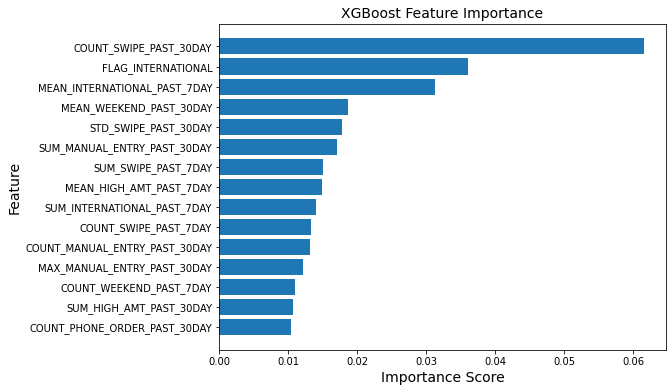

In [ ]:
plt.figure(figsize=(8,6))
plt.barh(X.columns[top_15][::-1], importances[top_15][::-1])
plt.title('XGBoost Feature Importance', fontsize=14)
plt.xlabel('Importance Score',fontsize=14)
plt.ylabel('Feature',fontsize=14)
plt.show()

# Revenue

In [ ]:
def revenue(X, y, decision, tn_rev_rate = 0.02, fn_exp_rate = 1):
    rev = X[np.logical_and(y == 0, decision == False)]['AMOUNT'].sum()* \
          tn_rev_rate
    exp = X[np.logical_and(y == 1, decision == False)]['AMOUNT'].sum()* \
          fn_exp_rate
    return rev - exp

In [ ]:
print('f1_opt_t:', f1_opt_t, ', revenue at f1_opt_t:', revenue(X_test, y_test, prob_test>f1_opt_t))

f1_opt_t: 0.21 , revenue at f1_opt_t: 18507.1074


In [ ]:
rev_opt, rev_opt_t, rev_lst = optimal(prob_test, y_test, partial(revenue, X_test))
print('rev_opt_t:', rev_opt_t, ', revenue at rev_opt_t:', rev_opt)

rev_opt_t: 0.03 , revenue at rev_opt_t: 29046.602199999998


In [ ]:
print('test_metrics: t=rev_opt_t\n')
metrics(y_test, prob_test >= rev_opt_t)

test_metrics: t=rev_opt_t

F1: 0.385502471169687
Precision: 0.2463157894736842
Recall: 0.8863636363636364
Conf Matrix: [[20348  1432]
 [   60   468]]


### Plotting Revenue and F1 as a function of threshold

In [ ]:
_,_ ,f1_lst = optimal(prob_test, y_test, f1_score)

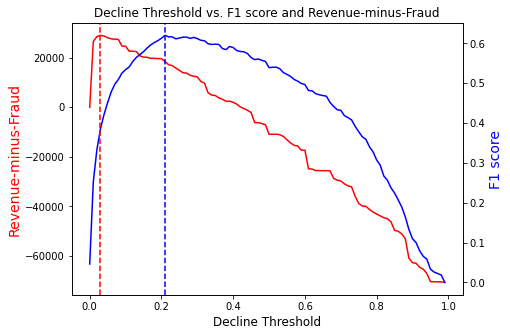

In [ ]:
fig,ax = plt.subplots(figsize=(7,5))
threshold = np.linspace(0,0.99, 100)
ax.plot(threshold, rev_lst, color="red")
ax.set_xlabel("Decline Threshold", fontsize = 12)
ax.set_ylabel("Revenue-minus-Fraud", color="red", fontsize=14)
ax2=ax.twinx()
ax2.plot(threshold, f1_lst, color="blue")
ax2.set_ylabel("F1 score",color="blue",fontsize=14)
plt.axvline(0.21, ls='--', color = 'blue')
plt.axvline(0.03, ls='--', color = 'red')
plt.title('Decline Threshold vs. F1 score and Revenue-minus-Fraud')
plt.show()

# Revenue-aware model

In [ ]:
rev_aware_model = train_xgboost(
    (X_train_np, y_train), 
    (X_test_np, y_test), 
    learning_rate=0.1,
    max_depth=15,
    min_child_weight=15,
    gamma=1.0,
    pos_weight = 50
)

In [ ]:
# calc probabilities
prob_test_rev_aware = prob(rev_aware_model, X_test_np)

rev_opt, rev_opt_t, rev_lst = optimal(prob_test_rev_aware, y_test, partial(revenue, X_test))
print('rev_opt_t:', rev_opt_t, ', revenue at rev_opt_t:', rev_opt)

rev_opt_t: 0.04 , revenue at rev_opt_t: 30991.973200000004


In [ ]:
print('test_metrics: t=rev_opt_t\n')
metrics(y_test, prob_test_rev_aware >= rev_opt_t)

test_metrics: t=rev_opt_t

F1: 0.3369527145359019
Precision: 0.20670391061452514
Recall: 0.9109848484848485
Conf Matrix: [[19934  1846]
 [   47   481]]


# Use conservative model on large transactions

In [ ]:
def high_value_filter(X, conservative_pred, risky_pred, val=150):
    pred = risky_pred.copy()
    high_val_idx = X['AMOUNT'] >= val
    pred[high_val_idx] = conservative_pred[high_val_idx]
    return pred

In [ ]:
mix_pred = high_value_filter(
    X_test, 
    prob_test >= rev_opt_t, 
    prob_test >= f1_opt_t
)

In [ ]:
metrics(y_test, mix_pred)

F1: 0.5656716417910448
Precision: 0.4667487684729064
Recall: 0.7178030303030303
Conf Matrix: [[21347   433]
 [  149   379]]


In [ ]:
revenue(X_test, y_test, mix_pred)

26982.066

# 2FA Experiment

In [ ]:
over_150 = (X_test['AMOUNT']>=150).to_numpy()
num_over_150 = sum(over_150)

# keep track of revenue and FP rate for each setting of TFA rate
tfa_rev = [] 
tfa_fpr = []

for i in range(0, 11):
    tf_rate = i/10
    to_flip = math.ceil(tf_rate * num_over_150)
    tf_y_pred = mix_pred.copy()

    if to_flip == 0:
        pass
    else:
        where = np.where(over_150)[0][:to_flip]
        for j in where:
            tf_y_pred[j] = y_test.iloc[j]

    tfa_rev.append(revenue(X_test, y_test, tf_y_pred))
    tfa_fpr.append(fpr(y_test, tf_y_pred))

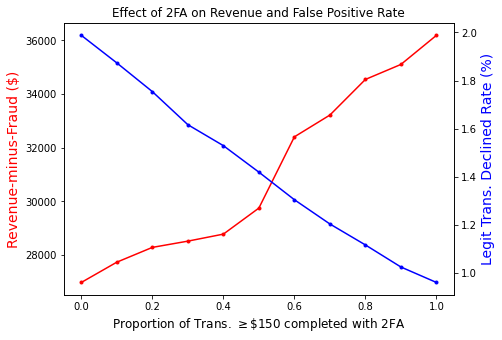

In [ ]:
tfa_percent = np.arange(11)/10
fig,ax = plt.subplots(figsize=(7,5))
ax.plot(tfa_percent, tfa_rev, color="red", marker='.')
ax.set_xlabel("Proportion of Trans. $\geq \$150$ completed with 2FA", fontsize = 12)
ax.set_ylabel("Revenue-minus-Fraud ($)", color="red", fontsize=14)
ax2=ax.twinx()
ax2.plot(tfa_percent, [x*100 for x in tfa_fpr], color="blue", marker='.')
ax2.set_ylabel("Legit Trans. Declined Rate (%)",color="blue",fontsize=14)
plt.title('Effect of 2FA on Revenue and False Positive Rate')
plt.show()


# Decline rate for $<\$150 $ and  $\geq\$150$

In [ ]:
mix_pred[over_150].sum()

349

In [ ]:
y_test[over_150].sum()/len(y_test[over_150])

0.05464698843238931

In [ ]:
mix_pred[~over_150].sum()/len(mix_pred[~over_150])

0.023382657441543355

# Correlation plot for features with top 10 correlation magnitudes with FRAUD_FLAG 

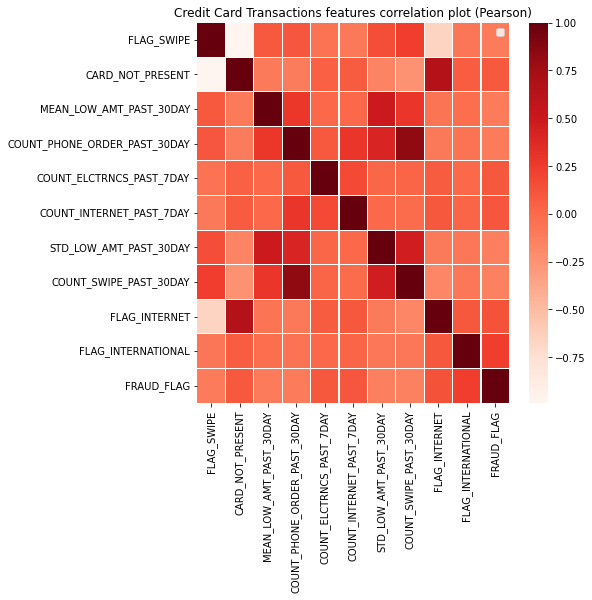

In [ ]:
df = pd.read_csv('train_ScotiaDSD.csv')
corr = df.corr()
top10_features = abs(corr['FRAUD_FLAG']).sort_values()
corr_cols = top10_features[(len(top10_features)-11):].index.values.tolist() # get the features names with highest correlation

df_corr = df[corr_cols] # get data only for the selected correlation columns

plt.figure(figsize = (7,7))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = df_corr.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

# Number of Fraud v/s Non-Fraud transactions made over the hours

Text(0, 0.5, 'No. of transactions')

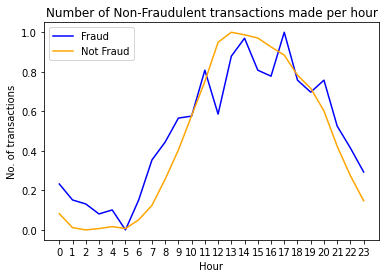

In [ ]:
# get only HOUR from time and plot it 
def extract_hours(x):
  return x.split(':')[0]

df['EVENT_TIME'] = df['EVENT_TIME'].apply(extract_hours)

# Fraud
fraud_hour_grouped = df[df['FRAUD_FLAG']==1.0].groupby('EVENT_TIME').size().reset_index()
fraud_hour_grouped['EVENT_TIME'] = fraud_hour_grouped['EVENT_TIME'].astype(int)
fraud_hour_grouped[0]=(fraud_hour_grouped[0]-fraud_hour_grouped[0].min())/(fraud_hour_grouped[0].max()-fraud_hour_grouped[0].min())
fraud = fraud_hour_grouped.sort_values(by='EVENT_TIME')

# Non-Fraud
NotFraud_hour_grouped = df[df['FRAUD_FLAG']!=1.0].groupby('EVENT_TIME').size().reset_index()
NotFraud_hour_grouped['EVENT_TIME'] = NotFraud_hour_grouped['EVENT_TIME'].astype(int)
NotFraud_hour_grouped[0]=(NotFraud_hour_grouped[0]-NotFraud_hour_grouped[0].min())/(NotFraud_hour_grouped[0].max()-NotFraud_hour_grouped[0].min())
notFraud = NotFraud_hour_grouped.sort_values(by='EVENT_TIME')

plt.plot(fraud['EVENT_TIME'],fraud[0], color="blue")
plt.plot(notFraud['EVENT_TIME'],notFraud[0], color="orange")
plt.legend(["Fraud","Not Fraud"])
plt.title("Number of Non-Fraudulent transactions made per hour")
plt.xlabel("Hour")
plt.xticks(notFraud['EVENT_TIME'])
plt.ylabel("No. of transactions")

# Distribution of Amount for Fraud v/s Not Fraud

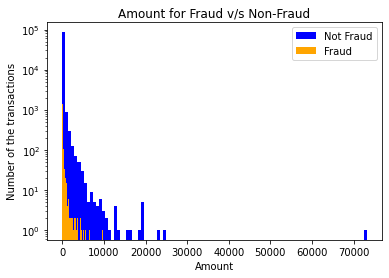

In [ ]:
# Amount for Fraud v/s Not Fraud Transactions 

bins = 100
plt.title("Amount for Fraud v/s Not Fraud")
plt.hist(df.AMOUNT[df.FRAUD_FLAG == 0], bins = bins, color='blue')
plt.hist(df.AMOUNT[df.FRAUD_FLAG == 1], bins = bins,color = 'orange')

plt.legend(["Not Fraud","Fraud"])
plt.xlabel('Amount')
plt.yscale("log")
plt.ylabel('Number of the transactions')
plt.show()